In [1]:
import pickle
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, KFold, 
    cross_val_score, GridSearchCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    classification_report, auc, 
    roc_auc_score, accuracy_score,
    make_scorer
)

from sklearn.pipeline import Pipeline

%matplotlib inline

 **Heart Dataset Columns Description**
 - Age : Age of the patient

 - Sex : Sex of the patient

 - exang: exercise induced angina (1 = yes; 0 = no)

 - ca: number of major vessels (0-3)

 - cp : Chest Pain type chest pain type

  - Value 1: typical angina
  - Value 2: atypical angina
  - Value 3: non-anginal pain
  - Value 4: asymptomatic
 - trtbps : resting blood pressure (in mm Hg)

 - chol : cholestoral in mg/dl fetched via BMI sensor

 - fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

 - rest_ecg : resting electrocardiographic results

  - Value 0: normal
  - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
  - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
 - thalach : maximum heart rate achieved

 - target : 0= less chance of heart attack 1= more chance of heart attack


In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.1
VALID_SIZE = 0.1

In [3]:
heart_df = pd.read_csv("data/heart.csv")
heart_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
oxygen_saturation_df = pd.read_csv("data/o2Saturation.csv")
oxygen_saturation_df.head()

,98.6
0,98.6
1,98.6
2,98.6
3,98.1
4,97.5


In [5]:
heart_df.shape

(303, 14)

In [6]:
oxygen_saturation_df.shape

(3585, 1)

In [7]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [8]:
assert heart_df.isna().sum().sum() == 0

In [9]:
## drop any duplicated values
heart_df.drop_duplicates(inplace=True)

## Data Exploration

In [10]:
def count_and_props(col_name):
    """find the counts and props of each class in a categorical column"""
    print("Counts: ")
    print(heart_df[col_name].value_counts())

    print("\nProportions: ")
    print(heart_df[col_name].value_counts(normalize=True))

In [11]:
## Count and Proportion of Output Type
count_and_props("output")

Counts: 
1    164
0    138
Name: output, dtype: int64

Proportions: 
1    0.543046
0    0.456954
Name: output, dtype: float64


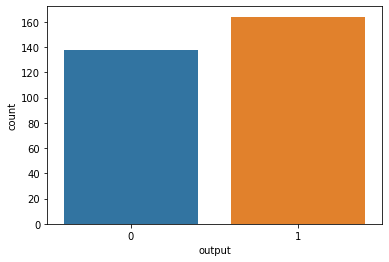

In [12]:
sns.countplot(x="output", data=heart_df);

In [13]:
## Count and Proportion of the exng Column
count_and_props("exng")

Counts: 
0    203
1     99
Name: exng, dtype: int64

Proportions: 
0    0.672185
1    0.327815
Name: exng, dtype: float64


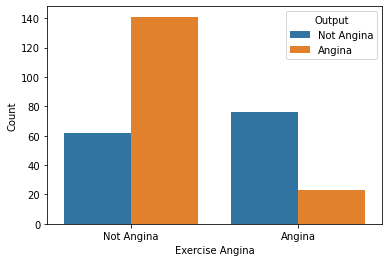

In [14]:
## How many got angina due to exercise?
sns.countplot(x="exng", data=heart_df, hue="output");
plt.xticks([0, 1], ["Not Angina", "Angina"]);
plt.legend(["Not Angina", "Angina"], title="Output");
plt.xlabel("Exercise Angina");
plt.ylabel("Count");

In [15]:
## Chest Pain Counts and Props
count_and_props("cp")

Counts: 
0    143
2     86
1     50
3     23
Name: cp, dtype: int64

Proportions: 
0    0.473510
2    0.284768
1    0.165563
3    0.076159
Name: cp, dtype: float64


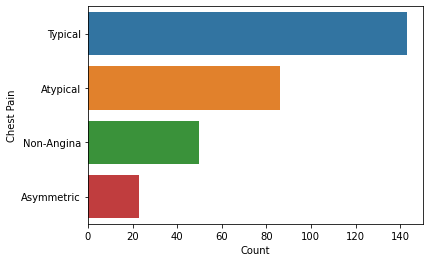

In [16]:
sns.countplot(y="cp", data=heart_df, 
              order=(heart_df["cp"].value_counts()
                     .sort_values(ascending=False).index))
plt.yticks([0,1,2,3], ["Typical", "Atypical", "Non-Angina", "Asymmetric"]);
plt.ylabel("Chest Pain");
plt.xlabel("Count");

In [17]:
## fbs (Fasting Blood Suger) Count
count_and_props("fbs")

Counts: 
0    257
1     45
Name: fbs, dtype: int64

Proportions: 
0    0.850993
1    0.149007
Name: fbs, dtype: float64


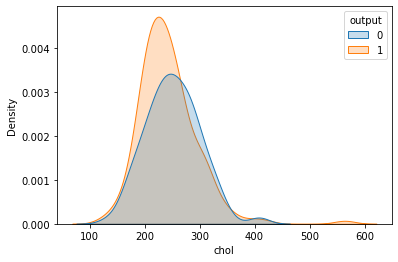

In [18]:
## Cholestrol Levels (chol) Dist vs Angina Output
sns.kdeplot(x="chol", data=heart_df, hue="output", shade=True);

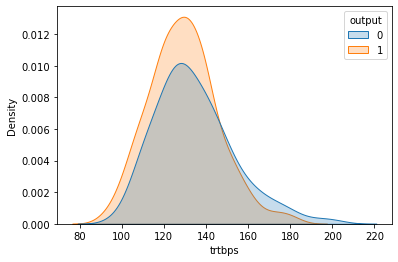

In [19]:
## resting blood pressure Dist.vs Angina Output
sns.kdeplot(x="trtbps", data=heart_df, hue="output", shade=True);

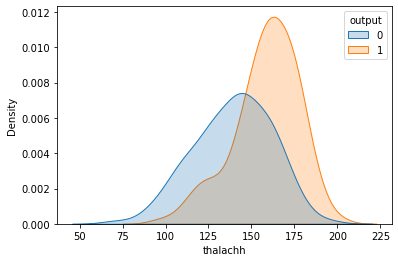

In [20]:
## Maximum Heart Rate Acheiced (thalach) Dist.vs Angina Output
sns.kdeplot(x="thalachh", data=heart_df, hue="output", shade=True);

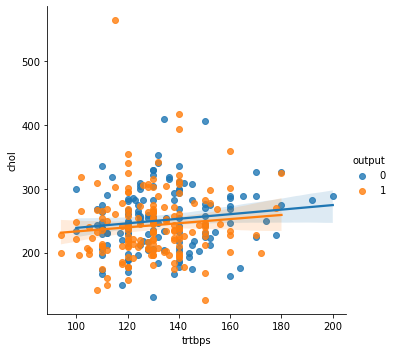

In [21]:
## Relation between Cholestrol Levels and Blood Pressure vs Angina Output?
sns.lmplot(x="trtbps", y="chol", data=heart_df, hue="output");

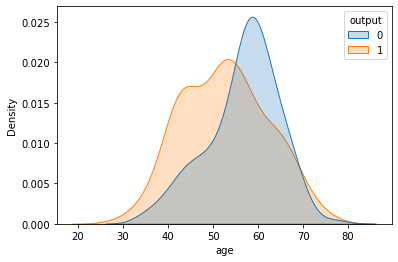

In [22]:
## Dist of the Age vs Angina output?
sns.kdeplot(x="age", data=heart_df, hue="output", shade=True);

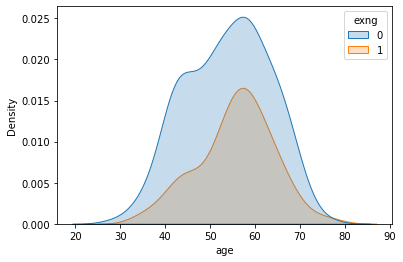

In [23]:
## Dist of the Age vs Excerise Angina?
sns.kdeplot(x="age", data=heart_df, hue="exng", shade=True);

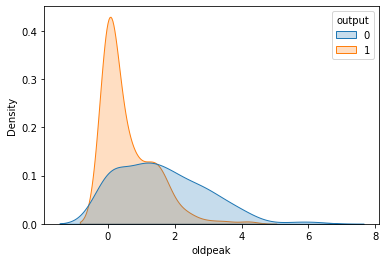

In [24]:
## Dist of the oldpeak columns vs Angina Output?
sns.kdeplot(x="oldpeak", data=heart_df, hue="output", shade=True);

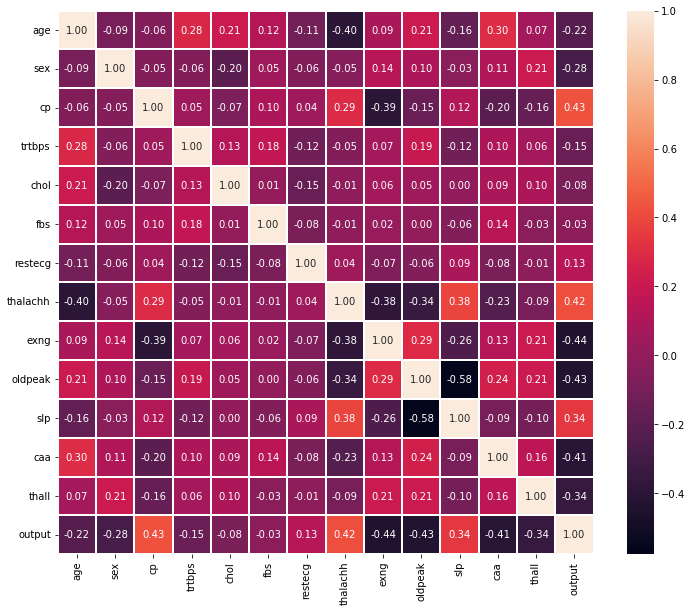

In [25]:
## Check the Correlation between the variables?
corr = heart_df.corr()

fig = plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt="0.2f", linewidths=0.1);

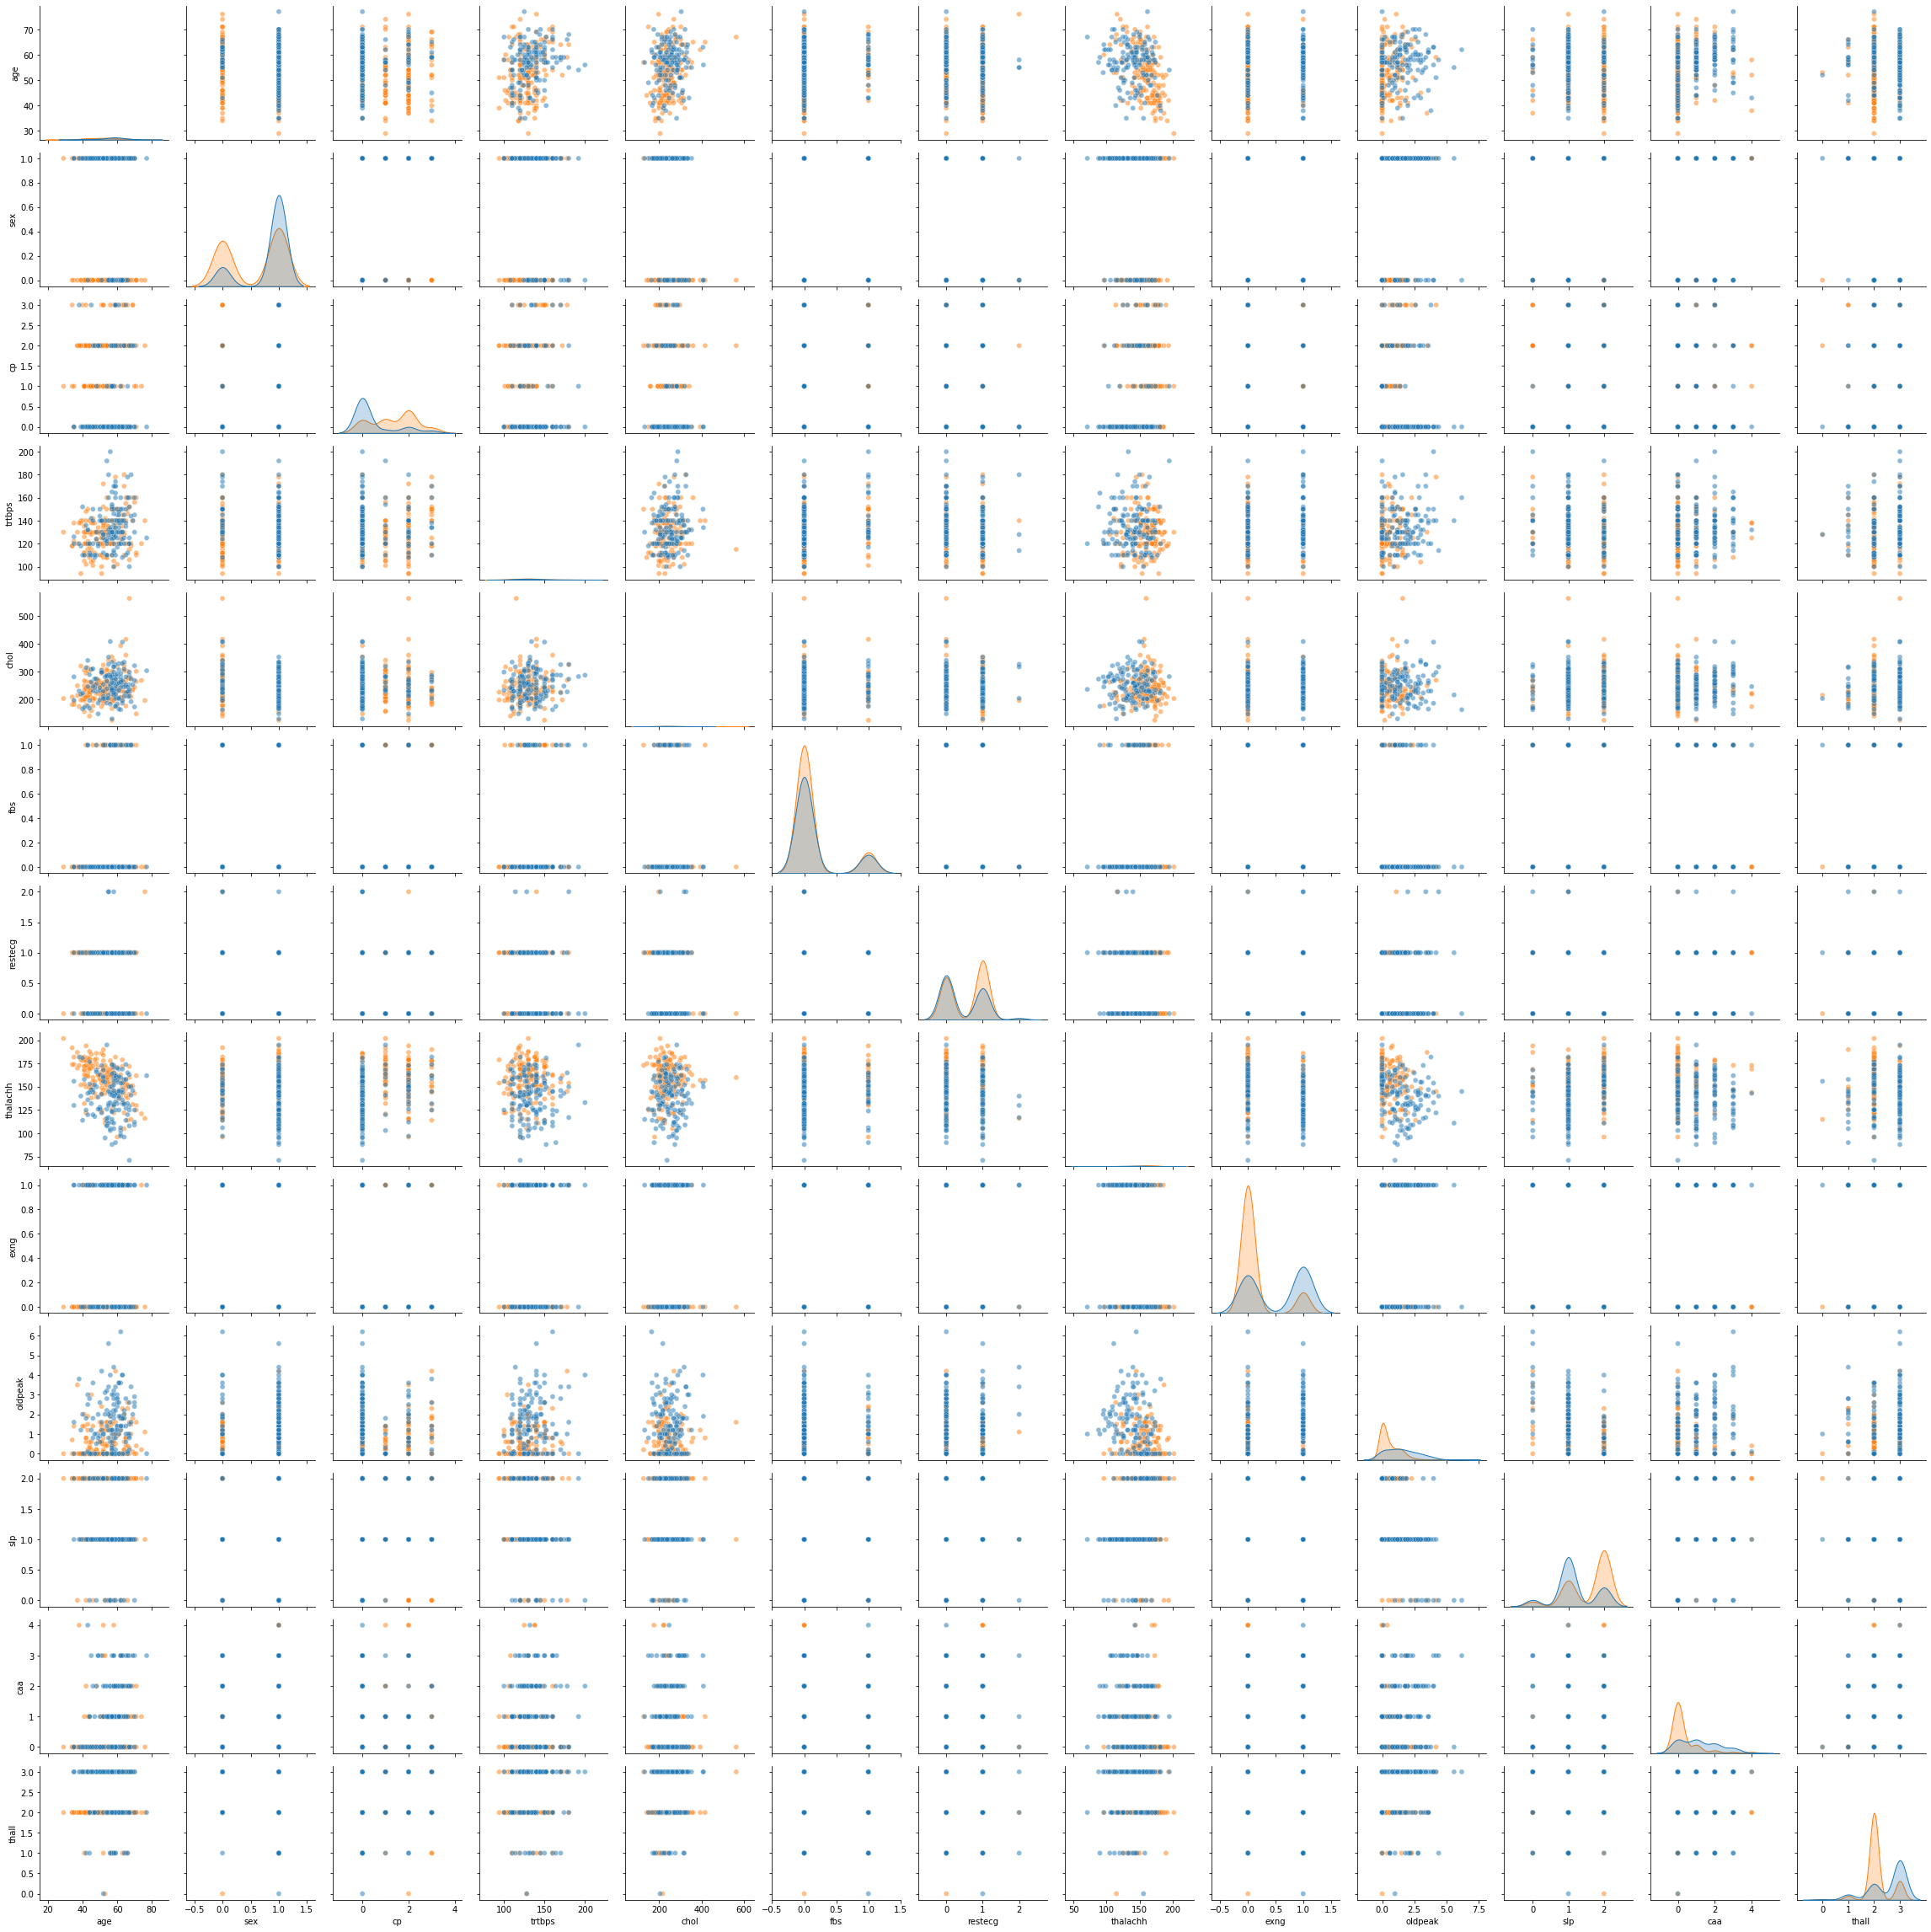

In [26]:
COLS = ["cp", "thalachh", "exng", "oldpeak", "caa", "fbs"]
g = sns.PairGrid(heart_df, hue="output")
g.map_diag(sns.kdeplot, shade=True)
g.map_offdiag(sns.scatterplot, alpha=0.5);

## Data Transformation

In [27]:
## convert the cp and restecg to OneHotEncoding
DUMMY_COLS = ["cp", "restecg"]
heart_df[DUMMY_COLS] = heart_df[DUMMY_COLS].astype("category")

heart_df_dummed = pd.concat([heart_df, pd.get_dummies(heart_df[DUMMY_COLS])], axis=1)
heart_df_dummed = heart_df_dummed.drop(DUMMY_COLS, axis=1)
heart_df_dummed.head()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,output,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2
0,63,1,145,233,1,150,0,2.3,0,0,1,1,0,0,0,1,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,2,1,0,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,2,1,0,1,0,0,1,0,0
3,56,1,120,236,0,178,0,0.8,2,0,2,1,0,1,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,2,1,1,0,0,0,0,1,0


In [28]:
target = heart_df_dummed["output"]
features = heart_df_dummed.drop("output", axis=1)

features.shape

(302, 18)

### Data Balancing (Angina Output)
dont have imblearn install with `$ pip install imblearn`

In [29]:
from imblearn.over_sampling import SMOTE

balancer = SMOTE(random_state=RANDOM_STATE)
features_res, target_res = balancer.fit_resample(features, target)

counts = target_res.value_counts()
assert counts.loc[0] == counts.loc[1]

In [30]:
## Splittig the Data into Train, Test and Valid

X_temp, X_test, y_temp, y_test = train_test_split(features_res, target_res, random_state=RANDOM_STATE,
                                                  test_size=TEST_SIZE, shuffle=True)
assert X_temp.shape[1] == X_test.shape[1]

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, random_state=RANDOM_STATE,
                                                  test_size=TEST_SIZE, shuffle=True)
assert X_train.shape[1] == X_val.shape[1]

print("Training Set Shape : ", X_train.shape)
print("Testing Set Shape : ", X_test.shape)
print("Validation Set Shape : ", X_val.shape)

Training Set Shape :  (265, 18)
Testing Set Shape :  (33, 18)
Validation Set Shape :  (30, 18)


In [31]:
## convert X_train, X_test, and X_val to DataFrames
feature_columns = features_res.columns

X_train = pd.DataFrame(X_train, columns=feature_columns)
X_test = pd.DataFrame(X_test, columns=feature_columns)
X_val = pd.DataFrame(X_val, columns=feature_columns)

print(X_train.head(3))
print("="*50)
print(X_test.head(3))
print("="*50)
print(X_val.head(3))

     age  sex  trtbps  chol  fbs  thalachh  exng  oldpeak  slp  caa  thall  \
238   35    1     126   282    0       156     1      0.0    2    0      3   
183   50    1     150   243    0       128     0      2.6    1    0      3   
44    39    1     140   321    0       182     0      0.0    2    0      2   

     cp_0  cp_1  cp_2  cp_3  restecg_0  restecg_1  restecg_2  
238     1     0     0     0          1          0          0  
183     1     0     0     0          1          0          0  
44      0     0     1     0          1          0          0  
     age  sex  trtbps  chol  fbs  thalachh  exng  oldpeak  slp  caa  thall  \
231   55    1     160   289    0       145     1      0.8    1    1      3   
110   64    0     180   325    0       154     1      0.0    2    0      2   
250   43    1     132   247    1       143     1      0.1    1    4      3   

     cp_0  cp_1  cp_2  cp_3  restecg_0  restecg_1  restecg_2  
231     1     0     0     0          1          0          

### Data Scalling

In [32]:
SCALING_COLS = ["age", "chol", "trtbps", "oldpeak"]

scaler = StandardScaler()
scaler.fit(X_train[SCALING_COLS])

X_train[SCALING_COLS] = scaler.transform(X_train[SCALING_COLS])
X_test[SCALING_COLS] = scaler.transform(X_test[SCALING_COLS])
X_val[SCALING_COLS] = scaler.transform(X_val[SCALING_COLS])


print(X_train.head(3))
print("="*50)
print(X_test.head(3))
print("="*50)
print(X_val.head(3))

          age  sex    trtbps      chol  fbs  thalachh  exng   oldpeak  slp  \
238 -2.212262    1 -0.344181  0.746546    0       156     1 -0.969657    2   
183 -0.536625    1  1.025650 -0.062891    0       128     0  1.340761    1   
44  -1.765426    1  0.454887  1.555983    0       182     0 -0.969657    2   

     caa  thall  cp_0  cp_1  cp_2  cp_3  restecg_0  restecg_1  restecg_2  
238    0      3     1     0     0     0          1          0          0  
183    0      3     1     0     0     0          1          0          0  
44     0      2     0     0     1     0          1          0          0  
          age  sex    trtbps      chol  fbs  thalachh  exng   oldpeak  slp  \
231  0.021920    1  1.596412  0.891830    0       145     1 -0.258759    1   
110  1.027302    0  2.737937  1.639002    0       154     1 -0.969657    2   
250 -1.318589    1 -0.001723  0.020128    1       143     1 -0.880795    1   

     caa  thall  cp_0  cp_1  cp_2  cp_3  restecg_0  restecg_1  restecg_2  

## Data Modeling

In [33]:
def train_and_predict(clf, X_train, y_train, X_val, y_val):
    """
        function to train a generic classifier on train data 
        and use it prediction to evaluate it performance.
        
    Parameters
    ----------
     - clf (Classifier)    : sklearn generic classifier.
     - X_train (np.ndarray): training features with shape (m, n)
     - y_train (np.ndarray): training targets with shape (m, 1)
     - X_val   (np.ndarray): validation features with shape (m, n)
     - y_val   (np.ndarray): validation targets with shape (m, 1)
     
    Returns
    -------
     - clf (Classifier) : fitted clf
     
     - results (dict) : the performace of the clf.
    """
    
    results = dict()
    
    # fit the model
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    results["train_time"] = end - start
    
    # predict
    start = time()
    y_pred = clf.predict(X_val)
    end = time()
    
    results["test_time"] = end - start
    
    results["acc"] = accuracy_score(y_val, y_pred)
    
    # print clf performance metrics
    print("Using Model [{}]".format(type(clf).__name__))
    print(classification_report(y_val, y_pred), "\n")
    
    print("Train Time : {:.5f}".format(results["train_time"]))
    print("ROC AUC : {:.5f}".format(roc_auc_score(y_val, y_pred)))
    print("="*54, "\n")
    
    return clf, results


In [34]:
lg_clf, lg_res = train_and_predict(LogisticRegression(solver="liblinear"), X_train, y_train, X_val, y_val)

rf_clf, rf_res = train_and_predict(RandomForestClassifier(), X_train, y_train, X_val, y_val)

gb_clf, gb_res = train_and_predict(GradientBoostingClassifier(), X_train, y_train, X_val, y_val)

ab_clf, ab_res = train_and_predict(AdaBoostClassifier(), X_train, y_train, X_val, y_val)

dt_clf, dt_res = train_and_predict(DecisionTreeClassifier(), X_train, y_train, X_val, y_val)

knn_clf, knn_res = train_and_predict(KNeighborsClassifier(), X_train, y_train, X_val, y_val)

Using Model [LogisticRegression]
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.80      0.67      0.73        18

    accuracy                           0.70        30
   macro avg       0.70      0.71      0.70        30
weighted avg       0.72      0.70      0.70        30
 

Train Time : 0.00803
ROC AUC : 0.70833

Using Model [RandomForestClassifier]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.83      0.83      0.83        18

    accuracy                           0.80        30
   macro avg       0.79      0.79      0.79        30
weighted avg       0.80      0.80      0.80        30
 

Train Time : 0.19757
ROC AUC : 0.79167

Using Model [GradientBoostingClassifier]
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.88      0.78      0.8

### Model Tuning (GradientBoostingClassifier)

In [35]:
## Using KFolds
clf = GradientBoostingClassifier()

cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

scorer = make_scorer(accuracy_score)

scores = cross_val_score(clf, X_train, y_train, scoring=scorer, cv=cv)

print("ACCURACY : {:.3f}, ACCURACY STD: {:.3f}".format(np.mean(scores), np.std(scores)))

ACCURACY : 0.807, ACCURACY STD: 0.068


In [36]:
## Using GridSearchCV

clf = GradientBoostingClassifier()

PARAMS = {
    "max_depth": [3, 4, 8],
    "n_estimators": [50, 100, 125, 150],
    "min_samples_split": [5, 9, 10, 14],
}

grid = GridSearchCV(clf, param_grid=PARAMS, scoring=scorer, cv=cv, verbose=1)

grid_obj = grid.fit(X_train, y_train)

best_clf = grid_obj.best_estimator_

y_pred = best_clf.predict(X_val)

print(classification_report(y_val, y_pred))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.88      0.83      0.86        18

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



## Production (Pipeline)

In [37]:
target = heart_df["output"]
features = heart_df.drop("output", axis=1)

## Splittig the Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=RANDOM_STATE,
                                                  test_size=TEST_SIZE, shuffle=True)
assert X_train.shape[1] == X_test.shape[1]


print("Training Set Shape : ", X_train.shape)
print("Testing Set Shape : ", X_test.shape)
print("Validation Set Shape : ", X_val.shape)

Training Set Shape :  (271, 13)
Testing Set Shape :  (31, 13)
Validation Set Shape :  (30, 18)


In [38]:
## best clf parameters
MAX_DEPTH = best_clf.max_depth
N_ESTIMATORS = best_clf.n_estimators
MIN_SAMPLES_SPLIT = best_clf.min_samples_split


transformer = ColumnTransformer(transformers=[
    ("onehot", OneHotEncoder(), DUMMY_COLS),
    ("scaler", StandardScaler(), SCALING_COLS),
])

pipe = Pipeline(steps=[
    ("transformer", transformer),
    ("gb_clf", GradientBoostingClassifier(
        max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS,
        min_samples_split=MIN_SAMPLES_SPLIT)
    ),
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['cp', 'restecg']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'chol', 'trtbps',
                                                   'oldpeak'])])),
                ('gb_clf',
                 GradientBoostingClassifier(max_depth=4, min_samples_split=14,
                                            n_estimators=50))])

In [39]:
## predict on the X_val
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.64      0.72        14
           1       0.75      0.88      0.81        17

    accuracy                           0.77        31
   macro avg       0.78      0.76      0.77        31
weighted avg       0.78      0.77      0.77        31



### Saving the Model

In [40]:
with open("models/best_gb_model.pkl", "wb") as f:
    pickle.dump(pipe, f)
    
!ls

 best_gb_model.pkl				       heart.csv
'Heart Attack Dataset Analysis and Prediction.ipynb'   o2Saturation.csv
